In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime
import scipy.stats

In [2]:
df_commodities = pd.read_csv("COMMODITIES.csv")

In [3]:
df_commodities = df_commodities[df_commodities["FREQUENCY"] != "15min"]


In [5]:
df_forex = pd.read_csv("FOREX.csv")
df_indices = pd.read_csv("INDICES.csv")
df_cryptos = pd.read_csv("CRYPTOS.csv")

In [6]:
# Definir la lista de DataFrames
dataframes = [df_indices, df_forex, df_cryptos, df_commodities]

# Definir las columnas deseadas
columnas_seleccionadas = ["BASE_CURRENCY", "TYPE", "DATE", "DATETIME", "CLOSE", "SYMBOL"]

# Crear una lista vacía para almacenar los resultados filtrados
df_filtrados = []

# Bucle for para iterar sobre los DataFrames
for df in dataframes:
    # Filtrar las columnas seleccionadas
    df_filtrado = df[columnas_seleccionadas]
    
    # Asegurarse de que la columna DATETIME esté en formato datetime
    df_filtrado['DATETIME'] = pd.to_datetime(df_filtrado['DATETIME'])
    
    # Ordenar los datos por DATETIME para asegurarnos de tener el último registro al final
    df_filtrado = df_filtrado.sort_values(by='DATETIME')
    
    # Filtrar el último registro de cada día para cada SYMBOL
    df_ultimo_symbol = df_filtrado.groupby(['SYMBOL', 'DATE']).tail(1)
    
    # Agregar el resultado filtrado a la lista
    df_filtrados.append(df_ultimo_symbol)

# Concatenar los resultados de los tres DataFrames en uno solo
df_final = pd.concat(df_filtrados)

# Mostrar el DataFrame final
print(df_final)


C:\Users\bako6\AppData\Local\Temp\ipykernel_11996\2444581205.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['DATETIME'] = pd.to_datetime(df_filtrado['DATETIME'])
C:\Users\bako6\AppData\Local\Temp\ipykernel_11996\2444581205.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['DATETIME'] = pd.to_datetime(df_filtrado['DATETIME'])
C:\Users\bako6\AppData\Local\Temp\ipykernel_11996\2444581205.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

       BASE_CURRENCY         TYPE        DATE            DATETIME  \
20567            USD      indices  2021-09-15 2021-09-15 06:00:00   
34               USD      indices  2021-09-15 2021-09-15 15:30:00   
70344            USD      indices  2021-09-15 2021-09-15 15:30:00   
34241            USD      indices  2021-09-15 2021-09-15 15:30:00   
106416           USD      indices  2021-09-15 2021-09-15 19:45:00   
...              ...          ...         ...                 ...   
24817            USD  COMMODITIES  2023-12-28 2023-12-28 00:00:00   
1832             USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
11995            USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
23277            USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
16663            USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   

               CLOSE       SYMBOL  
20567   30511.710938    Nikkei225  
34       8635.400391       IBEX35  
70344    4145.939941  EuroStoxx50  
34241   15616.000000       

C:\Users\bako6\AppData\Local\Temp\ipykernel_11996\2444581205.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['DATETIME'] = pd.to_datetime(df_filtrado['DATETIME'])


In [7]:
# 1. Filtrar el DataFrame para obtener los registros del símbolo XDGUSD
df_doge_symbol = df_final[df_final['SYMBOL'] == 'XDGUSD'].copy()

# 2. Renombrar la columna 'CLOSE' a 'label' para usarla más adelante
df_doge_symbol = df_doge_symbol[['DATE', 'CLOSE']].rename(columns={'CLOSE': 'label'})

# 3. Realizar un merge con el df_final, usando la columna DATE para emparejar los valores
df_doge = pd.merge(df_final, df_doge_symbol, on='DATE', how='left')

# 4. Filtrar de nuevo si solo quieres quedarte con los registros de DOGE
df_doge = df_doge[df_doge['SYMBOL'] != 'XDGUSD'].reset_index(drop=True)

# Mostrar el resultado
print(df_doge)

      BASE_CURRENCY         TYPE        DATE            DATETIME  \
0               USD      indices  2021-09-15 2021-09-15 06:00:00   
1               USD      indices  2021-09-15 2021-09-15 15:30:00   
2               USD      indices  2021-09-15 2021-09-15 15:30:00   
3               USD      indices  2021-09-15 2021-09-15 15:30:00   
4               USD      indices  2021-09-15 2021-09-15 19:45:00   
...             ...          ...         ...                 ...   
15221           USD  COMMODITIES  2023-12-28 2023-12-28 00:00:00   
15222           USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
15223           USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
15224           USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   
15225           USD  COMMODITIES  2023-12-29 2023-12-29 00:00:00   

              CLOSE       SYMBOL     label  
0      30511.710938    Nikkei225  0.247585  
1       8635.400391       IBEX35  0.247585  
2       4145.939941  EuroStoxx50  0.247585  
3  

In [8]:
# 1. Usar pivot_table para transformar el DataFrame
df_pivot_doge = df_doge.pivot_table(index='DATE', columns='SYMBOL', values='CLOSE')

# 2. (Opcional) Si quieres renombrar las columnas para que sean más claras
df_pivot_doge.columns = [f'{col}_CLOSE' for col in df_pivot_doge.columns]

# 3. Añadir la columna 'label' al DataFrame df_doge
df_labels = df_doge[['DATE', 'label']].drop_duplicates()

# 4. Hacer un merge para combinar los datos pivotados con la columna 'label'
df_pivot_doge = df_pivot_doge.reset_index()
df_final_doge = pd.merge(df_pivot_doge, df_labels, on='DATE', how='left')

# 5. Rellenar valores faltantes usando backward fill
df_final_doge = df_final_doge.fillna(method='bfill')


C:\Users\bako6\AppData\Local\Temp\ipykernel_11996\4210338086.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final_doge = df_final_doge.fillna(method='bfill')


In [9]:
df_final_doge.head()

,DATE,BZUSD_CLOSE,CLUSD_CLOSE,DAX_CLOSE,DowJones_CLOSE,ETHUSD_CLOSE,EuroStoxx50_CLOSE,GCUSD_CLOSE,IBEX35_CLOSE,LINKUSD_CLOSE,...,Nasdaq_CLOSE,Nikkei225_CLOSE,SP500_CLOSE,USDCHF_CLOSE,USDEUR_CLOSE,USDGBP_CLOSE,USDJPY_CLOSE,USDTUSD_CLOSE,XBTUSD_CLOSE,label
0,2021-01-01,51.09,47.62,15616.0,34814.128906,730.85,4145.939941,1946.6,8635.400391,11.87019,...,15503.533203,30511.710938,4480.700195,0.88409,0.82170,0.73130,102.996,1.0024,29398.9,0.005708
1,2021-01-02,51.09,47.62,15616.0,34814.128906,775.01,4145.939941,1946.6,8635.400391,12.20905,...,15503.533203,30511.710938,4480.700195,0.88409,0.81639,0.73092,102.996,1.0009,32238.8,0.010578
2,2021-01-03,51.09,47.62,15616.0,34814.128906,979.86,4145.939941,1946.6,8635.400391,13.69552,...,15503.533203,30511.710938,4480.700195,0.88409,0.81639,0.73092,102.996,1.0013,33082.7,0.009846
3,2021-01-04,51.09,47.62,15616.0,34814.128906,1042.52,4145.939941,1946.6,8635.400391,13.62239,...,15503.533203,30511.710938,4480.700195,0.88125,0.81486,0.73598,102.993,1.0007,32048.0,0.009792
4,2021-01-05,53.60,49.93,15616.0,34814.128906,1103.41,4145.939941,1954.4,8635.400391,14.54549,...,15503.533203,30511.710938,4480.700195,0.87872,0.81334,0.73471,102.820,1.0028,34050.0,0.010000


In [10]:
# Convertir la columna DATE a formato datetime si aún no lo está
df_final_doge['DATE'] = pd.to_datetime(df_final_doge['DATE'])

# Definir la fecha de corte
fecha_corte = pd.Timestamp('2021-09-06')

# Filtrar el DataFrame para quedarnos solo con los registros posteriores a la fecha de corte
df_filtered_doge = df_final_doge[df_final_doge['DATE'] > fecha_corte]

In [11]:
df_filtered_doge.head()

,DATE,BZUSD_CLOSE,CLUSD_CLOSE,DAX_CLOSE,DowJones_CLOSE,ETHUSD_CLOSE,EuroStoxx50_CLOSE,GCUSD_CLOSE,IBEX35_CLOSE,LINKUSD_CLOSE,...,Nasdaq_CLOSE,Nikkei225_CLOSE,SP500_CLOSE,USDCHF_CLOSE,USDEUR_CLOSE,USDGBP_CLOSE,USDJPY_CLOSE,USDTUSD_CLOSE,XBTUSD_CLOSE,label
249,2021-09-07,71.69,68.35,15616.0,34814.128906,3432.33,4145.939941,1795.90002,8635.400391,28.24024,...,15503.533203,30511.710938,4480.700195,0.91930,0.844309,0.72570,110.289,1.0004,46882.1,0.254971
250,2021-09-08,72.60,69.30,15616.0,34814.128906,3500.00,4145.939941,1793.50000,8635.400391,27.14759,...,15503.533203,30511.710938,4480.700195,0.92065,0.846095,0.72647,110.192,1.0002,46073.4,0.256860
251,2021-09-09,71.45,68.14,15616.0,34814.128906,3423.99,4145.939941,1800.00000,8635.400391,27.97549,...,15503.533203,30511.710938,4480.700195,0.91659,0.845260,0.72194,109.867,1.0002,46389.6,0.252466
252,2021-09-10,72.92,69.72,15616.0,34814.128906,3206.93,4145.939941,1792.10000,8635.400391,26.37962,...,15503.533203,30511.710938,4480.700195,0.91800,0.846680,0.72270,109.905,1.0000,44842.2,0.239508
253,2021-09-11,73.51,70.45,15616.0,34814.128906,3265.83,4145.939941,1794.40000,8635.400391,26.98446,...,15503.533203,30511.710938,4480.700195,0.91814,0.846600,0.72250,109.914,1.0002,45137.4,0.240987


In [12]:
df_filtered_doge.shape

(846, 21)

<Axes: title={'center': 'BRENT'}>

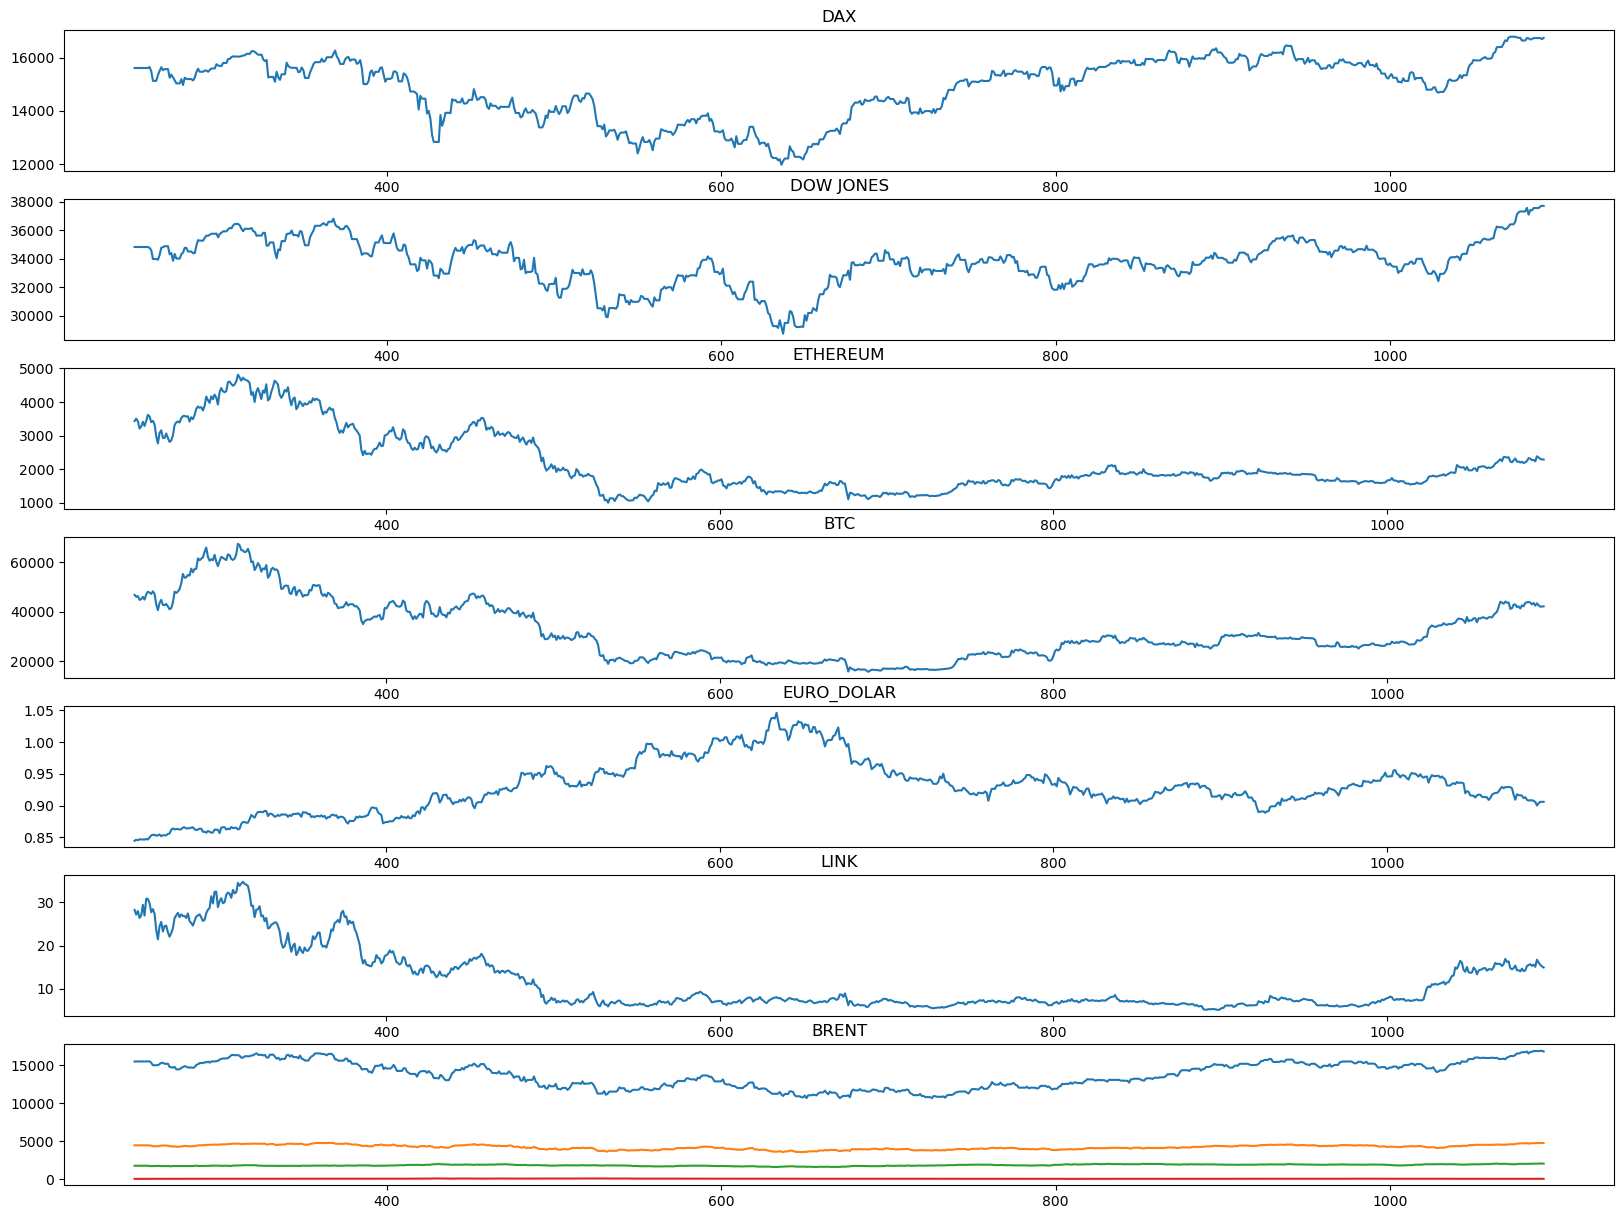

In [14]:
fig, axs = plt.subplots(ncols=1, nrows=7,figsize=(20, 15))
df_filtered_doge.DAX_CLOSE.plot(ax=axs[0], title = "DAX")
df_filtered_doge.DowJones_CLOSE.plot(ax=axs[1], title = "DOW JONES")
df_filtered_doge.ETHUSD_CLOSE.plot(ax=axs[2], title = "ETHEREUM")
df_filtered_doge.XBTUSD_CLOSE.plot(ax=axs[3], title = "BTC")
df_filtered_doge.USDEUR_CLOSE.plot(ax=axs[4], title = "EURO_DOLAR")
df_filtered_doge.LINKUSD_CLOSE.plot(ax=axs[5], title = "LINK")
df_filtered_doge.Nasdaq_CLOSE.plot(ax=axs[6], title = "NASDAQ")
df_filtered_doge.SP500_CLOSE.plot(ax=axs[6], title = "SP500")
df_filtered_doge.GCUSD_CLOSE.plot(ax=axs[6], title = "ORO")
df_filtered_doge.BZUSD_CLOSE.plot(ax=axs[6], title = "BRENT")

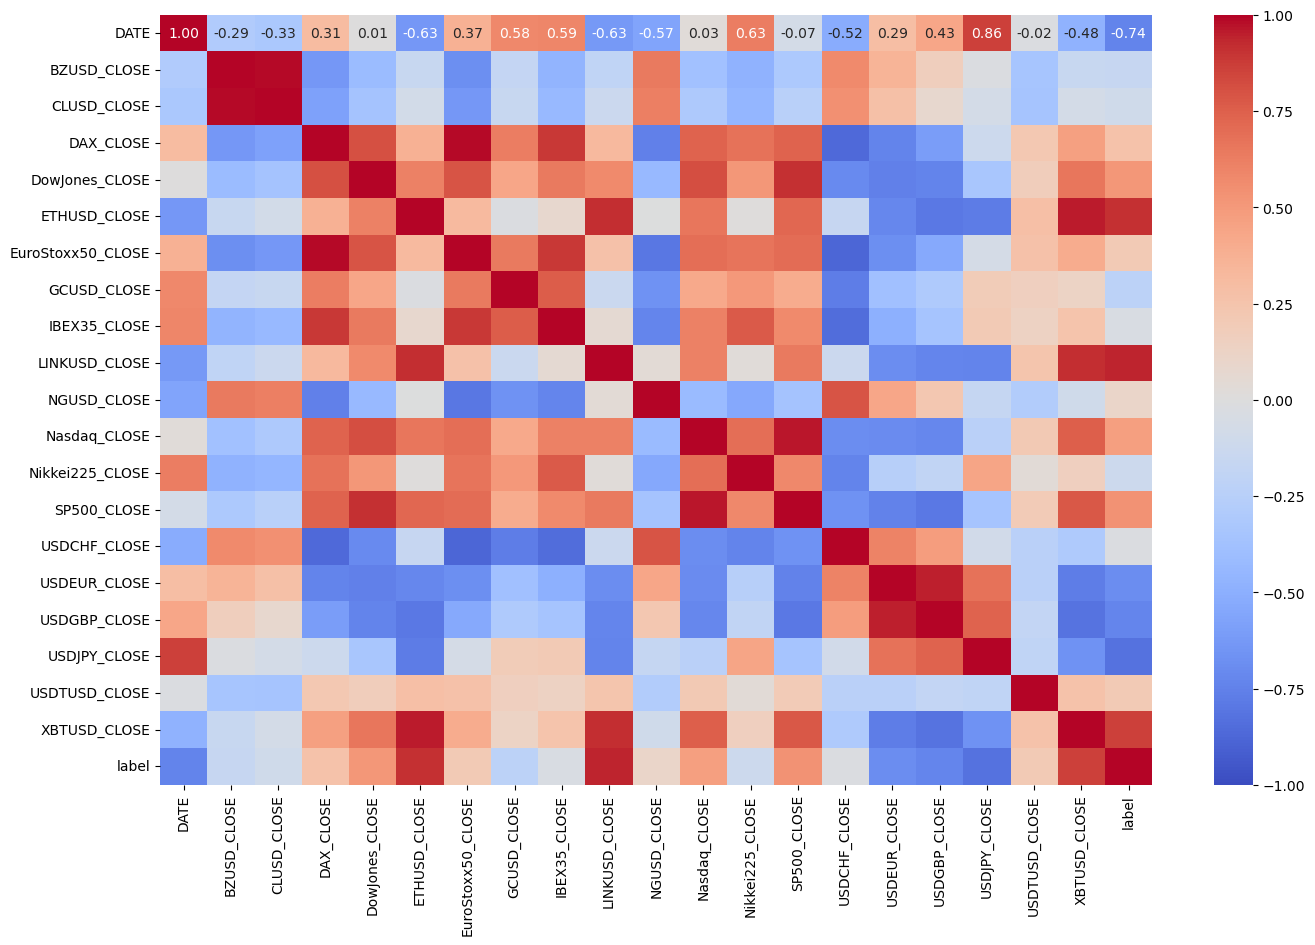

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que df_filtered_doge ya existe y es un DataFrame

# Crear una matriz de correlación
corr_matrix = df_filtered_doge.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 10))  # Ajusta el tamaño según sea necesario

# Crear el heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

# Mostrar el heatmap
plt.show()


C:\Users\bako6\AppData\Local\Temp\ipykernel_11996\2268573279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_doge['DATE'] = pd.to_datetime(df_filtered_doge['DATE'])


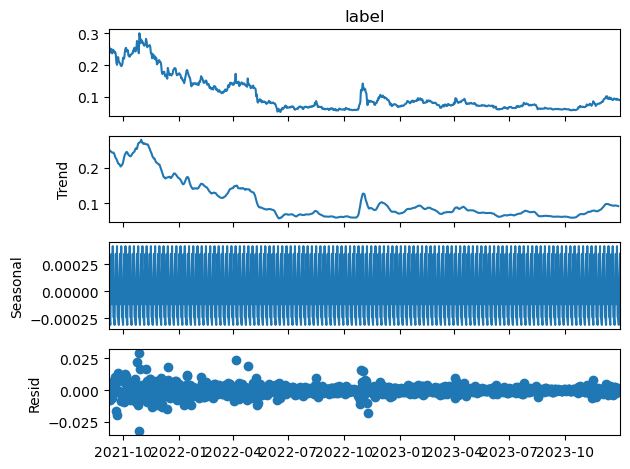

In [20]:
# Convertir la columna DATE a formato datetime si aún no lo está
df_filtered_doge['DATE'] = pd.to_datetime(df_filtered_doge['DATE'])

# Establecer la columna DATE como índice y asegurarnos de que tenga una frecuencia establecida
df_filtered_doge.set_index('DATE', inplace=True)
df_filtered_doge = df_filtered_doge.asfreq('D')  # Suponiendo que la frecuencia es diaria. Ajusta si es necesario.

# Realizar la descomposición de la serie temporal
decomposition = seasonal_decompose(df_filtered_doge['label'], model='additive')

# Representar la descomposición
decomposition.plot()
plt.show()

Vemos que la serie tiene estacionalidad por lo que vamos a necesitar realizar un modelo Sarimax para tratar la estacionalidad y poder meter variables exogenas
para verificar si la serie es estacionaria aplicamos el Test de Dickey-Fuller a la tendencia

In [21]:
sts.adfuller(decomposition.trend.dropna())

(-2.7495212156614195,
 0.06585389636057778,
 21,
 818,
 {'1%': -3.438369485934381,
  '5%': -2.865079774912655,
  '10%': -2.5686548826226527},
 -9088.60830903037)

Como se ve, como el resultado del test (-2.749...) es mayor que el valor del intervalo de confianza al 5% (y al 1 y al 10), no puedo rechazar la hipótesis nula, H0. Por tanto, la serie no es estacionaria.

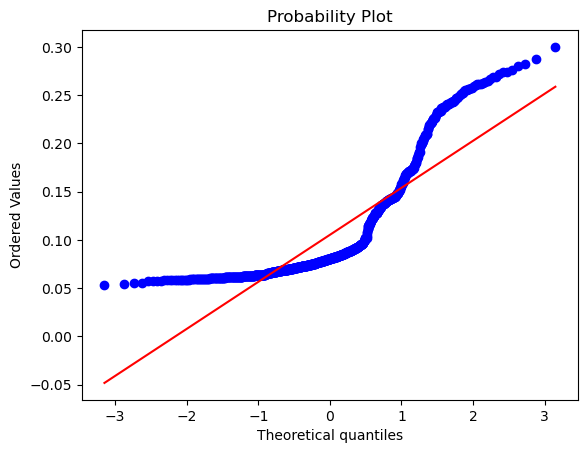

In [22]:
# Con el QQ Plot, también se puede determinar si la serie es estacionaria
scipy.stats.probplot(df_filtered_doge['label'], plot = plt);

Como la serie no se encuentra sobre la línea, significa que no sigue una distribución normal y, por tanto, se comprueba de nuevo que la serie no es estacionaria.

Ahora, hay que descomponer la componente de tendencia para poder determinar p, d y q del modelo ARIMA (P, D y Q no es necesario, ya que no se aprecia componente de estacionalidad en la serie temporal).

In [23]:
# Se eliminan los nulos de la tendencia, estacionalidad y residuos
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

**COMPONENTE DE TENDENCIA**

In [24]:
# Se hace el test de Dickey-Fuller para ver si es estacionaria la tendencia
sts.adfuller(trend)

(-2.7495212156614195,
 0.06585389636057778,
 21,
 818,
 {'1%': -3.438369485934381,
  '5%': -2.865079774912655,
  '10%': -2.5686548826226527},
 -9088.60830903037)

Como el resultado del test (-2.749...) es mayor que el valor del intervalo de confianza al 5% (y al 1%), no se puede rechazar la hipótesis nula. Por tanto, hay que diferenciar la tendencia hasta conseguir que sea estacionaria.

In [25]:
# Como la tendencia no es estacionaria, se diferencia
trend_diff = trend.diff()[1:]
sts.adfuller(trend_diff)

(-4.985094060890287,
 2.3751094051529507e-05,
 21,
 817,
 {'1%': -3.438379332805805,
  '5%': -2.865084115496387,
  '10%': -2.5686571948451586},
 -9121.575505323646)

Se observa que la tendencia ya es estacionaria (d = 1 si se pasa la tendencia sin diferenciar).

**COMPONENTE DE ESTACIONALIDAD:**
Como se ha comentado anteriormente, al fijar la frecuencia como diaria, no se aprecia estacionalidad en la serie temporal. El modelo a emplear será el ARIMA.

**COMPONENTE DE RESIDUOS**

In [26]:
# Test de Dickey-Fuller para saber si los residuos son ruido blanco
sts.adfuller(residual)

(-12.230011055759615,
 1.0588713966442898e-22,
 20,
 819,
 {'1%': -3.4383596631852327,
  '5%': -2.865075444948184,
  '10%': -2.568652576059133},
 -6877.582484768145)

No se puedo rechazar la hipótesis nula. Por tanto, se comprueba que los residuos son estacionarios y, por tanto, se puede modelar como ruido blanco (no aporta información a mi modelo).

**Autocorrelación (ACF) de la tendencia**

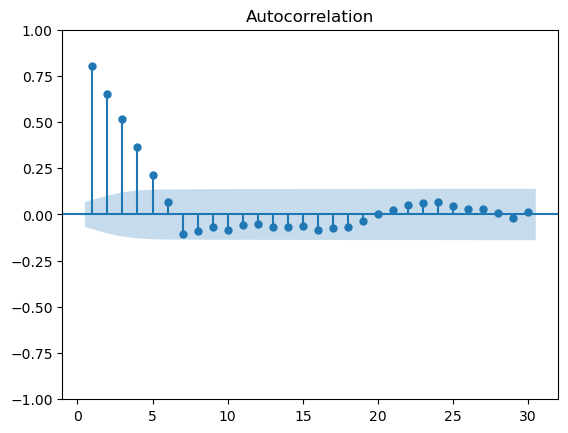

In [27]:
# Cálculo de autocorrelación para determinar q (como se usa la tendencia diferenciada, d = 0)
sgt.plot_acf(trend_diff, zero = False);

Como hay 5 palos antes de que el primero se encuentre dentro de la zona sombreada (que es el intervalo de confianza), q = 5.

**Autocorrelación parcial (PACF) de la tendencia**

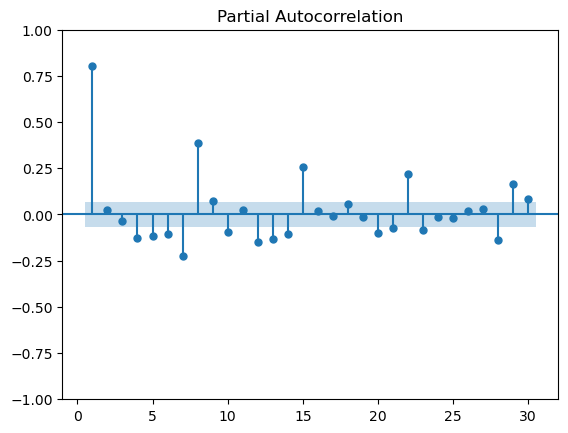

In [28]:
# Cálculo de autocorrelación parcial para determinar p (como se usa la tendencia diferenciada, d = 0)
sgt.plot_pacf(trend_diff, zero = False);

Como hay un palo antes de que el primero se encuentre en el límite del intervalo de confianza, p = 1.

Para la estacionalidad no es necesario estudiar el correlograma y el correlagrama parcial, ya que no se aprecia componente de estacionalidad en la serie temporal.

Ya se han determinado los parámetros del modelo ARIMA a utilizar: p = 1, d = 1 y q = 5. Se procede ahora a dividir el dataset en train y test:

In [29]:
train = df_filtered_doge[:592]
test = df_filtered_doge[592:]

Text(0, 0.5, 'label')

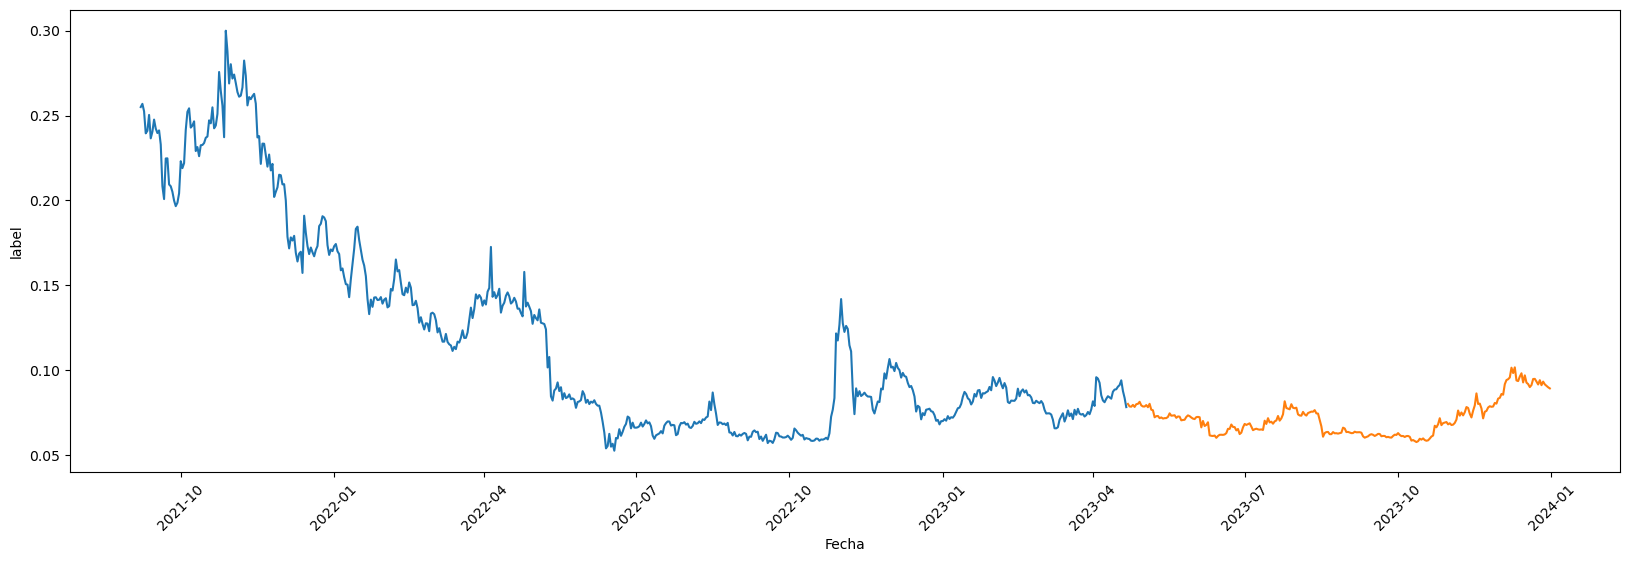

In [30]:
plt.figure(figsize=(20, 6))
plt.plot(train["label"])
plt.plot(test["label"])
plt.xticks(rotation = 45)
plt.xlabel("Fecha")
plt.ylabel("label")

In [31]:
from statsmodels.tsa.arima.model import ARIMA
modeloARIMA =ARIMA (train["label"], order=(1, 1, 5))
                        
resultados = modeloARIMA.fit()

In [32]:
inicio_prediccion = len(train)
fin_prediccion = len(test)
test["prediccion"] = resultados.predict(
    start=inicio_prediccion-1,
    end=inicio_prediccion + fin_prediccion)

C:\Users\bako6\AppData\Local\Temp\ipykernel_11996\91361092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediccion"] = resultados.predict(


Text(0, 0.5, 'label')

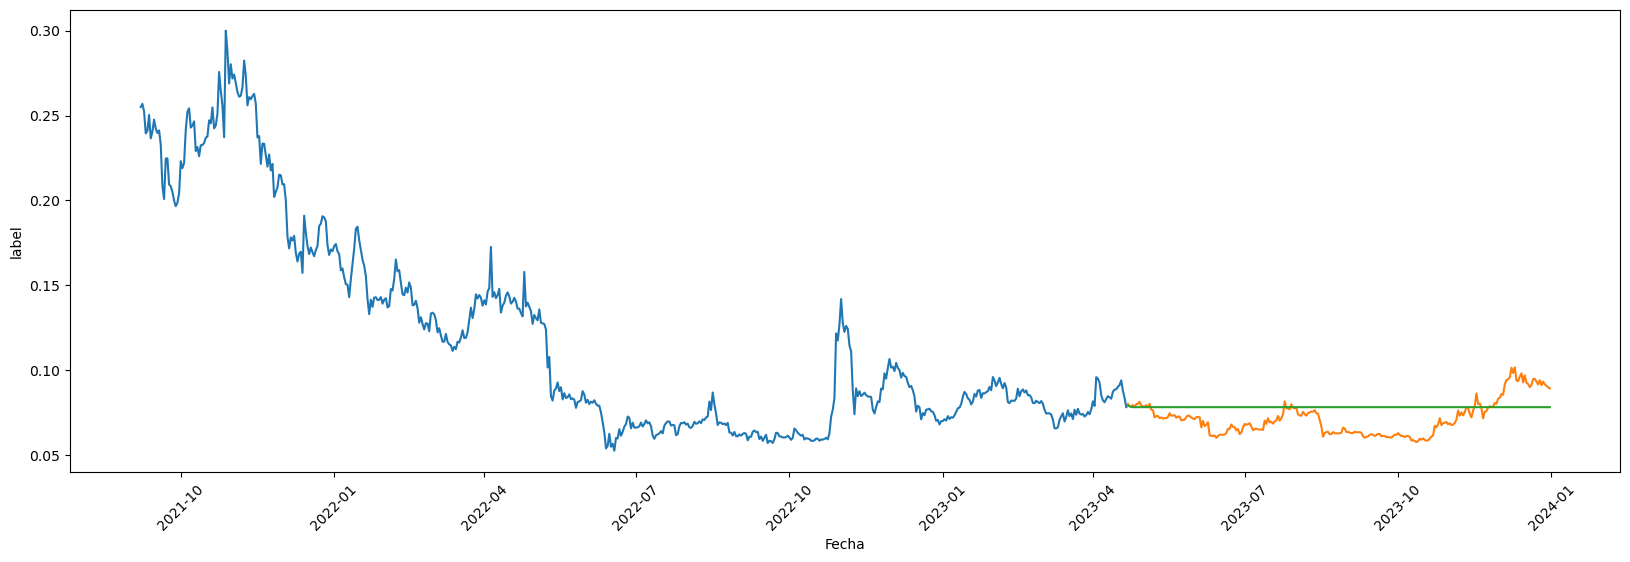

In [33]:
plt.figure(figsize=(20, 6))
plt.plot(train["label"])
plt.plot(test["label"])
plt.plot(test["prediccion"])
plt.xticks(rotation = 45)
plt.xlabel("Fecha")
plt.ylabel("label")

In [34]:
# Cálculo del RMSE del modelo ARIMA utilizado
rmse = mean_squared_error(test["label"], test["prediccion"], squared = False)
print(f"Root mean squared error: {rmse}")

Root mean squared error: 0.012026394105726888


In [35]:
# Se define y entrena el modelo ARIMAX (SARIMAX sin estacionalidad)
modelo_ARIMAX_1 = SARIMAX(train["label"], exog = train[["XBTUSD_CLOSE", "SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]], order = (1, 1, 5))
ARIMAX_1 = modelo_ARIMAX_1.fit()

C:\Users\bako6\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
# Verificar si hay NaNs o inf en las variables exógenas
print(test[["XBTUSD_CLOSE", "SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]].isna().sum())  # Para NaNs
print(np.isinf(test[["XBTUSD_CLOSE", "SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]]).sum())  # Para inf


XBTUSD_CLOSE    0
SP500_CLOSE     2
GCUSD_CLOSE     2
Nasdaq_CLOSE    2
USDEUR_CLOSE    0
dtype: int64
XBTUSD_CLOSE    0
SP500_CLOSE     0
GCUSD_CLOSE     0
Nasdaq_CLOSE    0
USDEUR_CLOSE    0
dtype: int64


In [40]:
# Rellenar los valores NaN en las variables exógenas con forward fill
test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]] = test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]].fillna(method='ffill')

# Si quedan NaNs al principio, usa backward fill
test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]] = test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]].fillna(method='bfill')

# Verificar si aún hay valores NaN
print(test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]].isna().sum())  # Esto debería devolver 0 si todos los NaN han sido rellenados


Nasdaq_CLOSE    0
SP500_CLOSE     0
GCUSD_CLOSE     0
dtype: int64


C:\Users\bako6\AppData\Local\Temp\ipykernel_11996\806955227.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]] = test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]].fillna(method='ffill')
C:\Users\bako6\AppData\Local\Temp\ipykernel_11996\806955227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]] = test[["Nasdaq_CLOSE","SP500_CLOSE","GCUSD_CLOSE"]].fillna(method='ffill')
C:\Users\bako6\AppData\Local\Temp\ipykernel_11996\806955227.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.b

In [46]:
print(test[["XBTUSD_CLOSE", "SP500_CLOSE", "GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]].shape)


(254, 5)


In [48]:
# Se realizan las predicciones con el modelo entrenado
test["XBTUSD_CLOSE", "SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"] = ARIMAX_1.predict(start = inicio_prediccion-1, end = inicio_prediccion-1 + fin_prediccion, exog = test[["XBTUSD_CLOSE", "SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]].values.reshape(254,5))

C:\Users\bako6\AppData\Local\Temp\ipykernel_11996\4066097987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["XBTUSD_CLOSE", "SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"] = ARIMAX_1.predict(start = inicio_prediccion-1, end = inicio_prediccion-1 + fin_prediccion, exog = test[["XBTUSD_CLOSE", "SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"]].values.reshape(254,5))


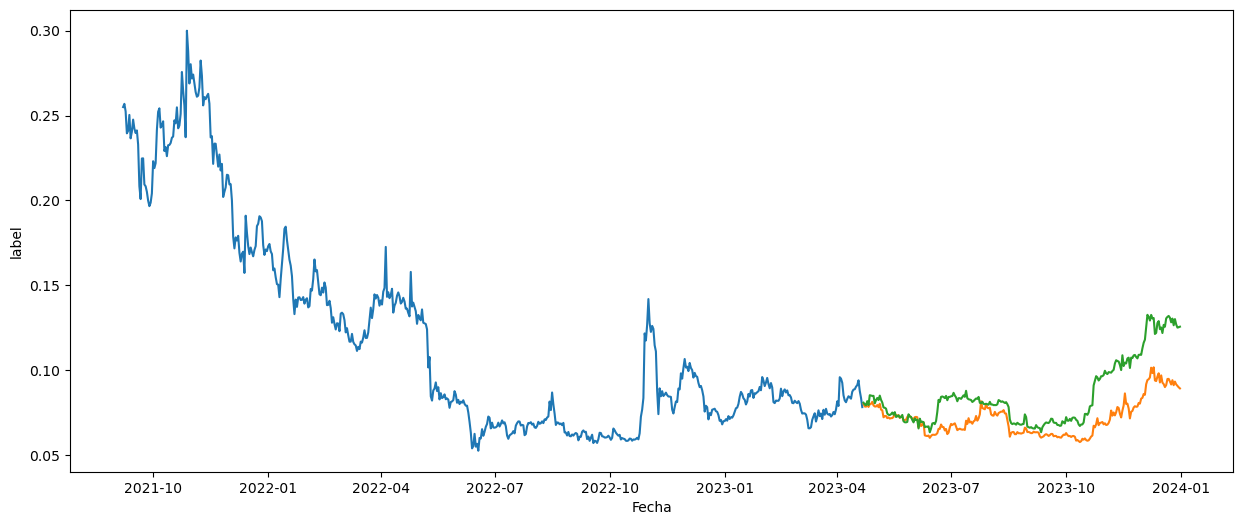

In [50]:
# Se representa gráficamente la predicción realizada con el modelo entrenado
plt.figure(figsize = (15, 6))
plt.plot(train["label"])
plt.plot(test["label"])
plt.plot(test["XBTUSD_CLOSE", "SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"])
plt.xlabel("Fecha")
plt.ylabel("label")
plt.show();

In [51]:
# Cálculo del RMSE del modelo ARIMAX utilizado
rmse = mean_squared_error(test["label"], test["XBTUSD_CLOSE", "SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"], squared = False)
print(f"Root mean squared error: {rmse}")

Root mean squared error: 0.01790765376280212


In [52]:
wape = ((test["XBTUSD_CLOSE", "SP500_CLOSE","GCUSD_CLOSE", "Nasdaq_CLOSE", "USDEUR_CLOSE"] -
         test["label"]).abs().sum()/
        test["label"].abs().sum()) * 100
print(f"El error WAPE es de: {wape}%")

El error WAPE es de: 19.07040097130941%


In [53]:
import pickle

# Guardar el modelo entrenado en un archivo .pkl
with open('modelo_arimax.pkl', 'wb') as f:
    pickle.dump(ARIMAX_1, f)
